In [2]:
#Importing All libararies
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from PIL import Image
import sys
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Saving the directory of correct images in a dataframe along with label
image_id = []
object_type = []
dir1 = '/content/drive/MyDrive/Dockship_Dataset/Garbage_Classification_AI_Challenge/garbage_classification_ai_challenge-dataset/TRAIN/'
for dirname in os.listdir(dir1):
    if dirname!='.DS_Store':
        for filename in os.listdir(dir1+dirname):
              image_id.append(dir1+dirname+'/'+filename)
              object_type.append(dirname)


In [5]:
#total no of images
len(image_id)

2001

In [6]:
df = pd.DataFrame(list(zip(image_id, object_type)),columns = ['ImageID','Type'])

In [7]:
# Shuffling the data frame
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
inp = df['ImageID']
out = df['Type']
inp, out

(0       /content/drive/MyDrive/Dockship_Dataset/Garbag...
 1       /content/drive/MyDrive/Dockship_Dataset/Garbag...
 2       /content/drive/MyDrive/Dockship_Dataset/Garbag...
 3       /content/drive/MyDrive/Dockship_Dataset/Garbag...
 4       /content/drive/MyDrive/Dockship_Dataset/Garbag...
                               ...                        
 1996    /content/drive/MyDrive/Dockship_Dataset/Garbag...
 1997    /content/drive/MyDrive/Dockship_Dataset/Garbag...
 1998    /content/drive/MyDrive/Dockship_Dataset/Garbag...
 1999    /content/drive/MyDrive/Dockship_Dataset/Garbag...
 2000    /content/drive/MyDrive/Dockship_Dataset/Garbag...
 Name: ImageID, Length: 2001, dtype: object, 0       cardboard
 1           metal
 2           paper
 3       cardboard
 4           glass
           ...    
 1996      plastic
 1997      plastic
 1998      plastic
 1999      plastic
 2000        paper
 Name: Type, Length: 2001, dtype: object)

In [9]:
#splitting the data set   
train_input, test_input, train_output, test_output = train_test_split(inp, out, random_state = 42,test_size = 0.2,stratify = out)      

In [10]:
train_input

901     /content/drive/MyDrive/Dockship_Dataset/Garbag...
503     /content/drive/MyDrive/Dockship_Dataset/Garbag...
424     /content/drive/MyDrive/Dockship_Dataset/Garbag...
851     /content/drive/MyDrive/Dockship_Dataset/Garbag...
668     /content/drive/MyDrive/Dockship_Dataset/Garbag...
                              ...                        
1901    /content/drive/MyDrive/Dockship_Dataset/Garbag...
465     /content/drive/MyDrive/Dockship_Dataset/Garbag...
1030    /content/drive/MyDrive/Dockship_Dataset/Garbag...
1203    /content/drive/MyDrive/Dockship_Dataset/Garbag...
37      /content/drive/MyDrive/Dockship_Dataset/Garbag...
Name: ImageID, Length: 1600, dtype: object

In [11]:
IMG_SIZE = 200
size = (IMG_SIZE,IMG_SIZE)

In [12]:
# Creating an object for imagedatagenerator for generating data in bacthes and augmentation
datagen = ImageDataGenerator(
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest'
)

In [13]:
train = pd.concat([train_input,train_output],axis=1)

In [14]:
# Visualising the class soplit
from collections import Counter 
Counter(object_type)

Counter({'cardboard': 323,
         'glass': 401,
         'metal': 328,
         'paper': 476,
         'plastic': 386,
         'trash': 87})

In [15]:
train_generator = datagen.flow_from_dataframe(
                    train,
                    x_col = "ImageID",
                    y_col = "Type",
                    target_size = size,
                    class_mode = "sparse",
                    batch_size = 64,
                    shuffle = True,
                    seed = 42,
                    interpolation = "nearest"
)

Found 1600 validated image filenames belonging to 6 classes.


In [16]:
test = pd.concat([test_input,test_output],axis=1)

In [17]:
valid_generator = datagen.flow_from_dataframe(
                    test,
                    x_col = "ImageID",
                    y_col = "Type",
                    target_size = size,
                    class_mode = "sparse",
                    batch_size = 64,
                    shuffle = False,
                    seed = 42,
                    interpolation = "nearest"
)

Found 401 validated image filenames belonging to 6 classes.


In [18]:
NUM_CLASSES = 6

In [48]:
def create_model():
    model = models.Sequential()
    model.add(EfficientNetB0(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet'))
    # model.add(layers.MaxPool2D())
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(NUM_CLASSES, activation = 'softmax'))
    return model

In [49]:
model = create_model()

In [71]:
model.compile(loss = 'sparse_categorical_crossentropy',
          optimizer = Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])

In [72]:
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               mode = 'min',
                               restore_best_weights = True)

# Save the model with the minimum validation loss
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf', 
                             monitor = 'val_loss',
                             verbose = 1,
                             mode = 'min', 
                             save_best_only = True)
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 0.001,
                              mode = 'min',
                              verbose = 1)

In [73]:
#Trying with 30 epochs
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = 30,
                    callbacks = [early_stopping, checkpoint, reduce_lr]
                    )

Epoch 1/30
25/25 [==============================] - 37s 1s/step - loss: 0.0463 - accuracy: 0.9873 - val_loss: 0.3351 - val_accuracy: 0.9277

Epoch 00001: val_loss improved from inf to 0.33512, saving model to /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


Epoch 2/30
25/25 [==============================] - 27s 1s/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.3291 - val_accuracy: 0.9327

Epoch 00002: val_loss improved from 0.33512 to 0.32915, saving model to /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


Epoch 3/30
25/25 [==============================] - 27s 1s/step - loss: 0.0103 - accuracy: 0.9992 - val_loss: 0.3231 - val_accuracy: 0.9401

Epoch 00003: val_loss improved from 0.32915 to 0.32310, saving model to /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


Epoch 4/30
25/25 [==============================] - 28s 1s/step - loss: 0.0071 - accuracy: 0.9991 - val_loss: 0.3029 - val_accuracy: 0.9377

Epoch 00004: val_loss improved from 0.32310 to 0.30292, saving model to /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


Epoch 5/30
25/25 [==============================] - 28s 1s/step - loss: 0.0176 - accuracy: 0.9939 - val_loss: 0.3521 - val_accuracy: 0.9227

Epoch 00005: val_loss did not improve from 0.30292
Epoch 6/30
25/25 [==============================] - 27s 1s/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 0.2917 - val_accuracy: 0.9526

Epoch 00006: val_loss improved from 0.30292 to 0.29173, saving model to /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


Epoch 7/30
25/25 [==============================] - 28s 1s/step - loss: 0.0130 - accuracy: 0.9959 - val_loss: 0.3104 - val_accuracy: 0.9377

Epoch 00007: val_loss did not improve from 0.29173
Epoch 8/30
25/25 [==============================] - 27s 1s/step - loss: 0.0135 - accuracy: 0.9936 - val_loss: 0.3196 - val_accuracy: 0.9377

Epoch 00008: val_loss did not improve from 0.29173
Epoch 9/30
25/25 [==============================] - 27s 1s/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.2705 - val_accuracy: 0.9426

Epoch 00009: val_loss improved from 0.29173 to 0.27050, saving model to /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


Epoch 10/30
25/25 [==============================] - 28s 1s/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.3654 - val_accuracy: 0.9327

Epoch 00010: val_loss did not improve from 0.27050
Epoch 11/30
25/25 [==============================] - 27s 1s/step - loss: 0.0059 - accuracy: 0.9978 - val_loss: 0.3058 - val_accuracy: 0.9401

Epoch 00011: val_loss did not improve from 0.27050
Epoch 12/30
25/25 [==============================] - 27s 1s/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.2653 - val_accuracy: 0.9352

Epoch 00012: val_loss improved from 0.27050 to 0.26526, saving model to /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


Epoch 13/30
25/25 [==============================] - 28s 1s/step - loss: 0.0097 - accuracy: 0.9958 - val_loss: 0.2495 - val_accuracy: 0.9401

Epoch 00013: val_loss improved from 0.26526 to 0.24955, saving model to /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf/assets


Epoch 14/30
25/25 [==============================] - 28s 1s/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.3134 - val_accuracy: 0.9277

Epoch 00014: val_loss did not improve from 0.24955
Epoch 15/30
25/25 [==============================] - 27s 1s/step - loss: 0.0098 - accuracy: 0.9973 - val_loss: 0.3562 - val_accuracy: 0.9302

Epoch 00015: val_loss did not improve from 0.24955
Epoch 16/30
25/25 [==============================] - 27s 1s/step - loss: 0.0064 - accuracy: 0.9973 - val_loss: 0.2786 - val_accuracy: 0.9426

Epoch 00016: val_loss did not improve from 0.24955
Epoch 17/30
25/25 [==============================] - 27s 1s/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.3214 - val_accuracy: 0.9252

Epoch 00017: val_loss did not improve from 0.24955
Epoch 18/30
25/25 [==============================] - 28s 1s/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.3095 - val_accuracy: 0.9377

Epoch 00018: val_loss did not improve from 0.24955


In [74]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Dockship_Dataset/Models/best_model.hdf')

In [75]:
#function which will return the probabilities of respective classes and the type of object
def predict(path):
  img = image.load_img(path=path ,target_size=(200, 200,3))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  # print(model.predict_classes(img_batch))
  prediction = saved_model.predict(img_batch)
  result= np.argmax(prediction,axis=1)
  class_indices = list(valid_generator.class_indices.keys())
  return (class_indices[result[0]],max(prediction[0])*100)

In [76]:
predict('/content/drive/MyDrive/Dockship_Dataset/Garbage_Classification_AI_Challenge/garbage_classification_ai_challenge-dataset/TEST/001.jpg')

('metal', 99.99991655349731)

In [77]:
result = []
for add in test_input:
  result.append(predict(add)[0])

In [78]:
result[:10]

['metal',
 'trash',
 'plastic',
 'metal',
 'plastic',
 'plastic',
 'metal',
 'metal',
 'paper',
 'glass']

In [79]:
list(test_output[:10])

['metal',
 'trash',
 'glass',
 'metal',
 'plastic',
 'glass',
 'metal',
 'metal',
 'paper',
 'glass']

In [80]:
confusion_matrix(list(test_output),result)

array([[64,  1,  0,  0,  0,  0],
       [ 0, 70,  1,  2,  7,  0],
       [ 0,  0, 65,  0,  1,  0],
       [ 0,  0,  0, 92,  1,  2],
       [ 0,  1,  1,  1, 73,  1],
       [ 0,  0,  2,  1,  0, 15]])

In [81]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

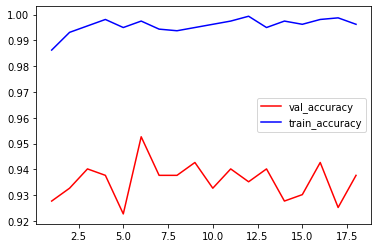

In [83]:
plt.plot(range(1,19),history.history['val_accuracy'],color='red',label='val_accuracy')
plt.plot(range(1, 19),history.history['accuracy'],color='blue',label='train_accuracy')
plt.legend()

In [84]:
history.history['loss']

[0.05031252279877663,
 0.01990796998143196,
 0.016069922596216202,
 0.00939631275832653,
 0.01656690239906311,
 0.009716418571770191,
 0.016945691779255867,
 0.014547241851687431,
 0.011457367800176144,
 0.012120891362428665,
 0.005949865095317364,
 0.004772422835230827,
 0.012311344034969807,
 0.007686179131269455,
 0.010087507776916027,
 0.005739489104598761,
 0.0054558957926929,
 0.007284445688128471]

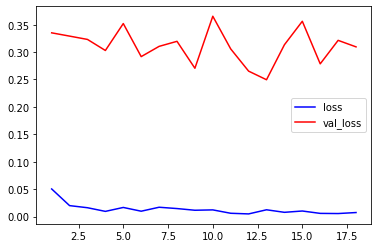

In [85]:
plt.plot(range(1,19),history.history['loss'],color='blue',label='loss')
plt.plot(range(1,19),history.history['val_loss'],color='red',label='val_loss')
plt.legend()

In [86]:
dir = '/content/drive/MyDrive/Dockship_Dataset/Garbage_Classification_AI_Challenge/garbage_classification_ai_challenge-dataset/TEST'
images = os.listdir(dir)

In [87]:
test_result = []
for filename in images:
  img = image.load_img(path="/content/drive/MyDrive/Dockship_Dataset/Garbage_Classification_AI_Challenge/garbage_classification_ai_challenge-dataset/TEST/"+str(filename) ,target_size=(200, 200,3))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  pred = saved_model.predict(img_batch)
  prediction= np.argmax(pred,axis=1)
  test_result.append(prediction)

In [88]:
pred = np.array(test_result).ravel()
labels = dict((v,k) for k,v in (valid_generator.class_indices).items())
pred = [labels[k] for k in pred]

In [89]:
df_new = pd.DataFrame(list(zip(images, pred)),columns = ['Filename','Labels'])

In [90]:
df_new

,Filename,Labels
0,251.jpg,plastic
1,081.jpg,metal
2,113.jpg,paper
3,142.jpg,glass
4,254.jpg,metal
...,...,...
295,212.jpg,paper
296,008.jpg,glass
297,250.jpg,cardboard
298,189.jpg,plastic


In [91]:
df_new.to_csv("/content/drive/MyDrive/Dockship_Dataset/Submissions/Garbage_Classification_submission.csv", index = False)